### z50 vs sigma z para distintos radios

subhalo_127000000000002


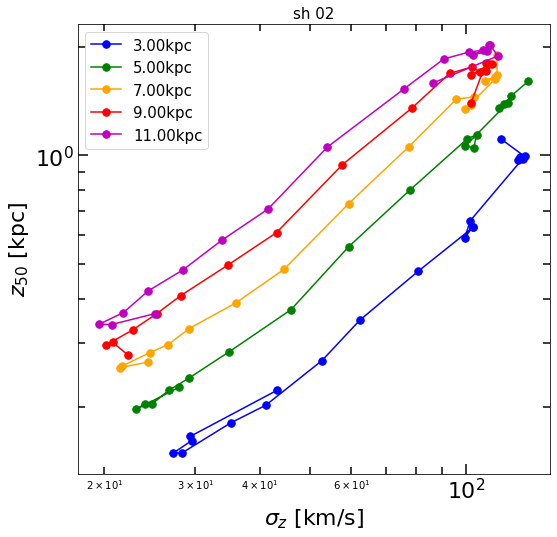

subhalo_127000000000003


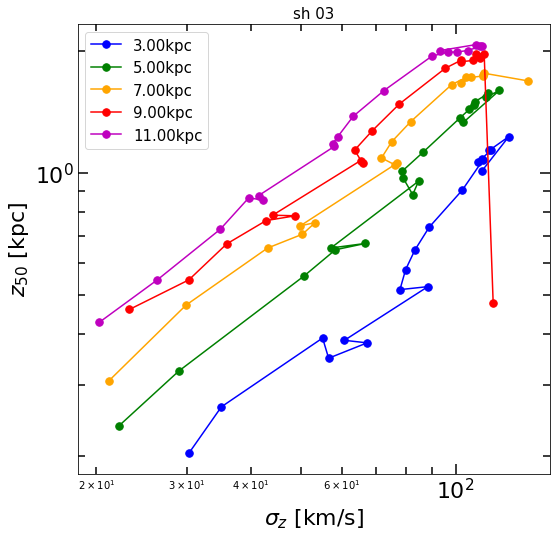

subhalo_127000000000004


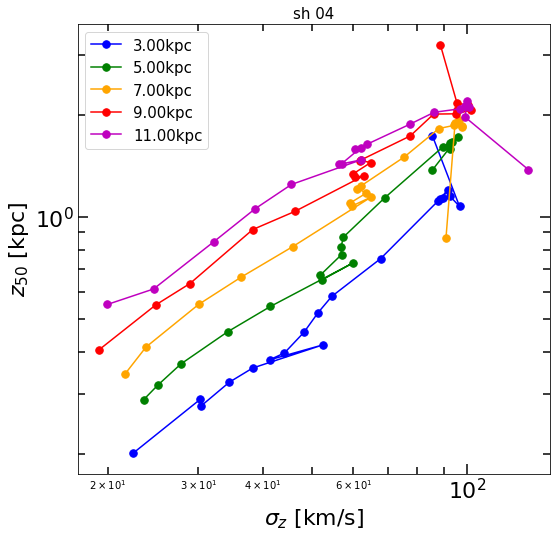

subhalo_127000000000006


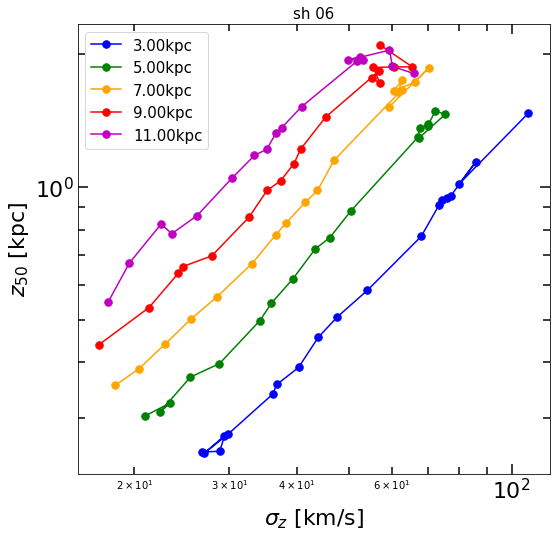

subhalo_127000000000007


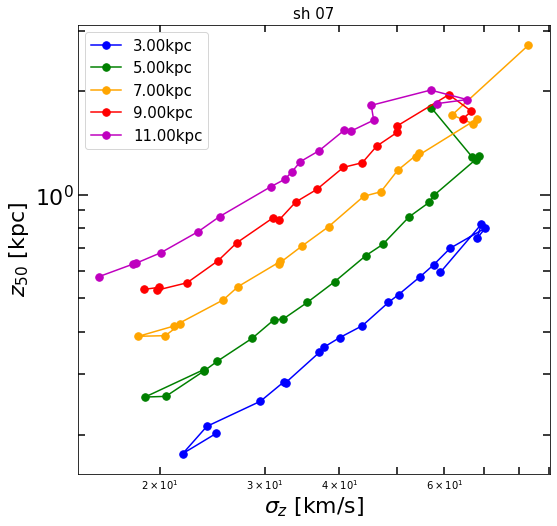

subhalo_127000000000009


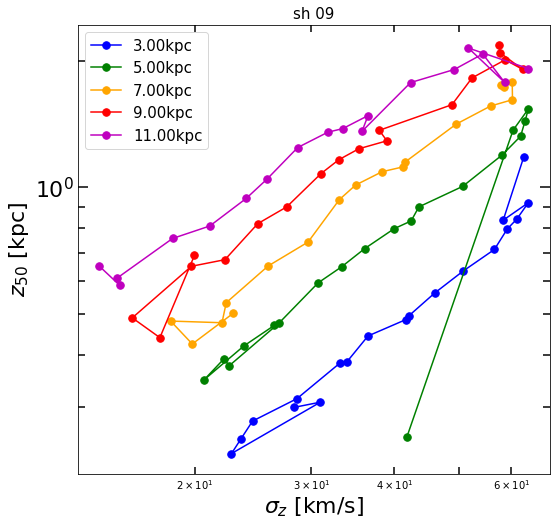

subhalo_127000000000012


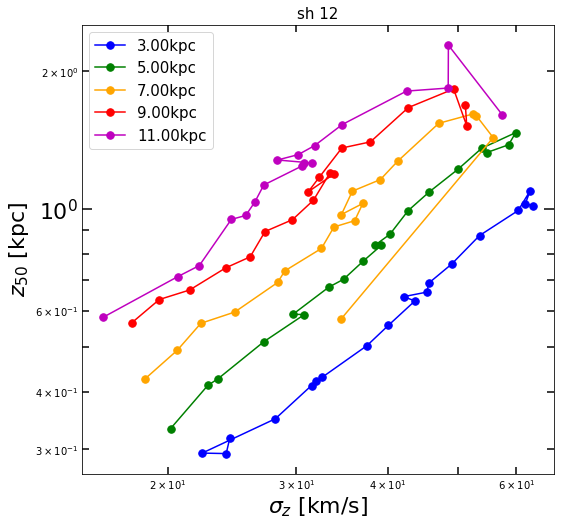

subhalo_127000000000011


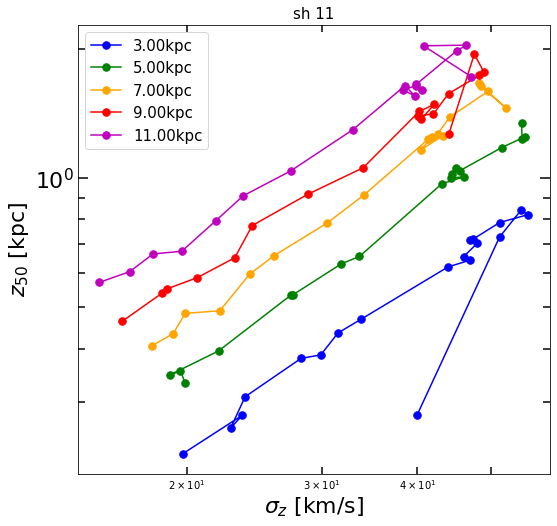

subhalo_127000000000014


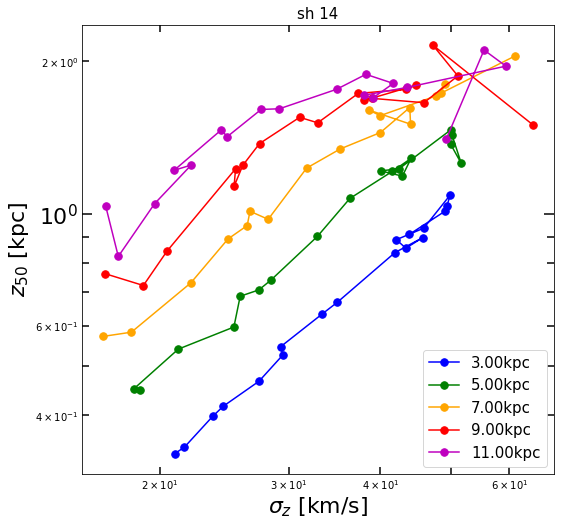

subhalo_127000000000020


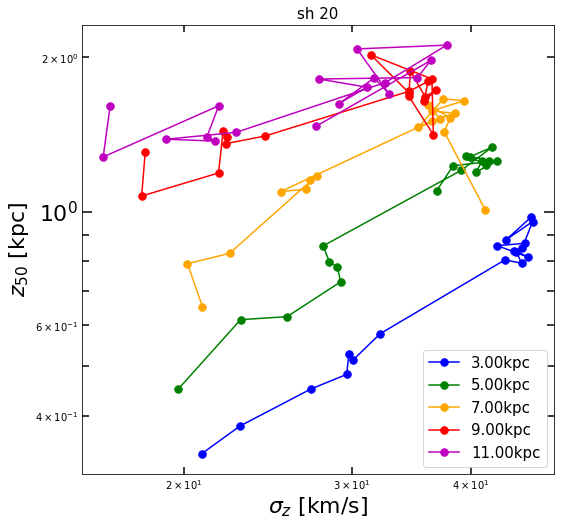

subhalo_127000000000021


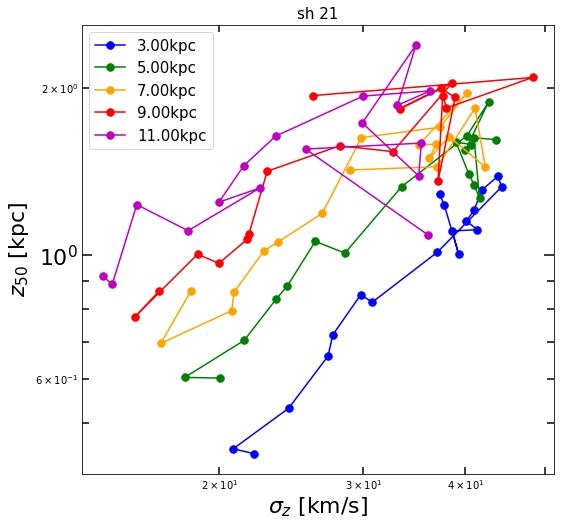

subhalo_127000000000023


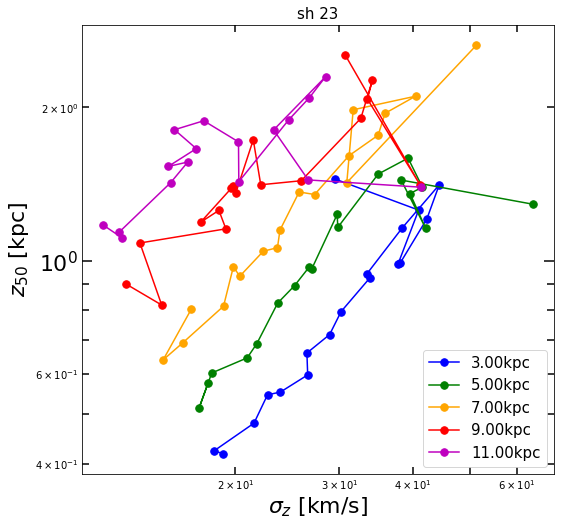

subhalo_127000000000028


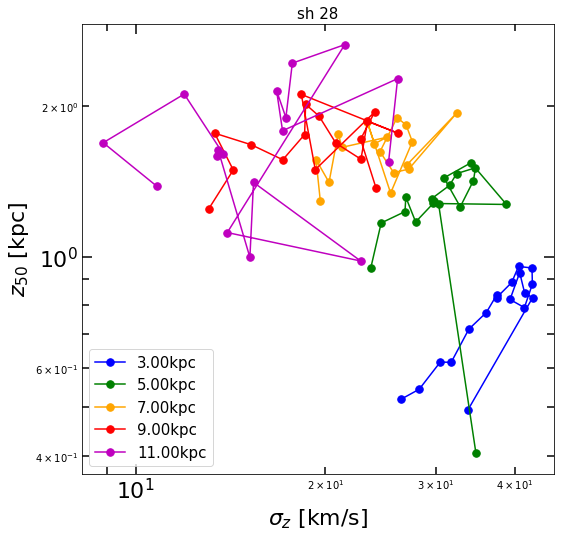

subhalo_127000000000031


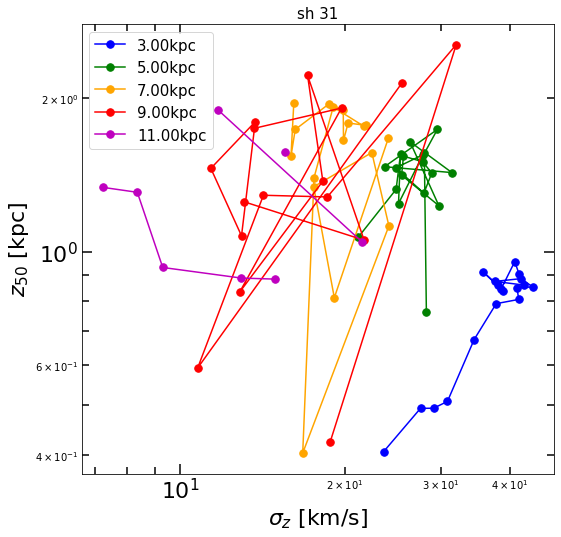

In [1]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import bines2 as bines
import matplotlib as mpl
import metallicity_profile as metp
import z50
import velocity_dispersion as vd

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/store/erebos/omarioni/_simulations/snap_127/'

colors = ('b', 'g', 'orange', 'r', 'm')

for j in range(14):

    snap = h5py.File(path + 'subhalo_'+str('%d'%ID[j])+'.h5py', 'r')

    print('subhalo_'+str('%d'%ID[j]))
    
    Id = ''
    for aux in list(str('%d'%ID[j]))[-2:]:
        Id += aux

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]
    Rvir = snap['/R200'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]

    sft  = snap['/Str/FormationTime'][()]
    met  = snap['/Str/Metallicity'][()]
    tmet = snap['/Str/Total_Metallicity'][()]

    amask, = np.where(sft>0) #aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)
    
    Ztot = tmet[amask]/0.0127

    xstr = pstr[amask,0]*aexp/h
    ystr = pstr[amask,1]*aexp/h
    zstr = pstr[amask,2]*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vstr[amask,0] *np.sqrt(aexp)
    v_y = vstr[amask,1] *np.sqrt(aexp)
    v_z = vstr[amask,2] *np.sqrt(aexp)

    #----------------------masas----------------------------
    mstr = mstr[amask]*1e10/h

    rgal = 0.15*Rvir*aexp/h

    limit, = np.where(rstr < rgal)
    rsort = np.argsort(rstr[limit])
    Mc = np.cumsum(mstr[limit][rsort])
    Mgal = Mc[-1]
    limit50, = np.where(Mc < Mgal/2)
    r50 = rstr[limit][rsort][limit50][-1]

    veloc,=np.where(rstr < r50/2.)

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,r50/2.)

    xn  = e1x*xstr + e1y*ystr + e1z*zstr
    yn  = e2x*xstr + e2y*ystr + e2z*zstr
    zn  = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    Rstr = np.sqrt(xn**2 + yn**2)
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    fig.subplots_adjust(bottom=0.15, left =0.15, right = 0.97, top = 0.93, wspace=0., hspace= 0)
    
    radius = (3,5,7,9,11)
    
    age_bin = np.linspace(0,14,20)
    
    for k in range(len(radius)):
        
        sigma_z = np.ones(len(age_bin))*np.nan
        z50_value = np.ones(len(age_bin))*np.nan
        
        
        gal, = np.where((Rstr < radius[k]+1) & (Rstr > radius[k]-1) & (zn < 5) & (zn > -5))

        edad  = age[gal]
        x_str = xn[gal]
        y_str = yn[gal]
        z_str = zn[gal]
        m_str = mstr[gal]

        for i in range(len(age_bin)-1):

            agelim, = np.where((edad>age_bin[i]) & (edad<age_bin[i+1]))

            if len(agelim)<2:
                continue

            edades = np.median(edad[agelim])
            z = z_str[agelim]
            m = m_str[agelim]

            sigma_z[i] = vd.vel_disp(vzn[gal][agelim])
            z50_value[i] = z50.z50v(z,m)
 
        ax.plot(sigma_z, z50_value,'o-',ms=7.5, color=colors[k], label=str('%2.2f'%radius[k])+'kpc')

    ax.minorticks_on()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params( labelsize=22)
    ax.tick_params('both', length=7, width=1.5,which='minor', direction='in', right='on',top='on')
    ax.tick_params('both', length=10, width=1.5,which='major', direction='in', right='on',top='on')
    ax.set_xlabel(r'$\sigma_z$ [km/s]',fontsize=22)
    ax.set_ylabel('$z_{50}$ [kpc]',fontsize=22)
    ax.set_title('sh '+Id,fontsize=15) 
    ax.legend(fontsize=15, fancybox=True)
    

    plt.show()
    
    fig.savefig('../_imagenes/veloc_disp/vd_z50_2_sh'+Id+'.png',dpi=75, xxbox_inches='tight')

In [2]:
import numpy as np

def zh_NSG(sig_z, Vdm, R):
    
    zh_nsg = np.sqrt(2)*sig_z*R/Vdm
    
    return zh_nsg

def zh_SG(sig_z, SIG, G = 4.299e-6):
    
    zh_sg = 2*sig_z**2 / (np.pi**(3/2)*G*SIG)
    
    return zh_sg
    